# Title : Covid19 Tweet Sentiment Analysis

Problem at hand : Sentiment Analysis. Predict 'sentiment' using tweets

# 0.Import and Preprocess Data

##0.1.Download Data

###0.1.1Download data from kaggle

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload() #and upload kaggle.json

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d datatattle/covid-19-nlp-text-classification

  0% 0.00/4.38M [00:00<?, ?B/s]
100% 4.38M/4.38M [00:00<00:00, 71.5MB/s]


In [ ]:
!unzip covid-19-nlp-text-classification.zip

Archive:  covid-19-nlp-text-classification.zip
  inflating: Corona_NLP_test.csv     
  inflating: Corona_NLP_train.csv    


###0.1.2.OR Download Data from colab

In [ ]:
!cp '/content/drive/My Drive/2.Projects/Covid Tweet Sentiment Classification/data/Corona_NLP_train.csv' Corona_NLP_train.csv
!cp '/content/drive/My Drive/2.Projects/Covid Tweet Sentiment Classification/data/Corona_NLP_test.csv' Corona_NLP_test.csv

## 0.1.Import data

In [ ]:
# Utils
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
# import logging

import logging
logging.basicConfig(level=logging.ERROR)

# Set log
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
train_df = pd.read_csv('Corona_NLP_train.csv', encoding='ISO-8859-1')
test_df = pd.read_csv('Corona_NLP_test.csv', encoding='ISO-8859-1')

##0.2.Simple EDA

In [ ]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


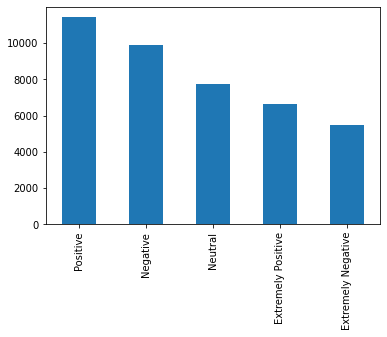

In [ ]:
train_df['Sentiment'].value_counts().plot.bar();

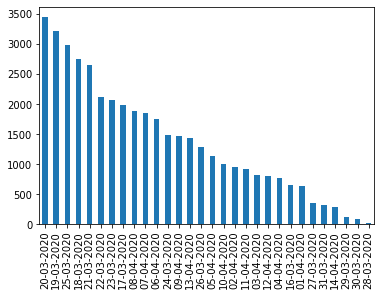

In [ ]:
train_df['TweetAt'].value_counts().plot.bar();

The data is a bit biased. We will take care of it after the preprocessing step, because some tweets get deleted as a whole during preprocessing

##0.3.Preprocess texts

In [ ]:
#Preprocess
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def preprocess(text, stem=True, return_type='string'):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    text = re.sub(r'\$\w*', '', text)
    # remove old style retweet text "RT"
    text = re.sub(r'^RT[\s]+', '', text)
    # remove hyperlinks
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    # remove hashtags
    # only removing the hash # sign from the word
    text = re.sub(r'#', '', text)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    text_tokens = tokenizer.tokenize(text)

    texts_clean = []
    for word in text_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            
            if stem:
            # tweets_clean.append(word)
                stem_word = stemmer.stem(word)  # stemming word
                texts_clean.append(stem_word)
            else : 
                texts_clean.append(word)
                        

    if return_type =='list':
        return texts_clean
    else:
        return " ".join(texts_clean)

In [ ]:
preprocessed = []
disappeared_train = []
for i, original_tweet in enumerate(tqdm(train_df['OriginalTweet'])):
    processed_tweet = preprocess(original_tweet)
    preprocessed.append(processed_tweet)
    if not processed_tweet:
        disappeared_train.append(i)

train_df['PreprocessedTweet'] = preprocessed


preprocessed = []
disappeared_test = []
for i, original_tweet in enumerate(tqdm(test_df['OriginalTweet'])):
    processed_tweet = preprocess(original_tweet)
    preprocessed.append(processed_tweet)
    if not processed_tweet:
        disappeared_test.append(i)

test_df['PreprocessedTweet'] = preprocessed

100%|██████████| 3798/3798 [00:02<00:00, 1457.07it/s]


In [ ]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,PreprocessedTweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advic talk neighbour famili exchang phone numb...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronaviru australia woolworth give elderli di...
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,food stock one empti ... pleas panic enough fo...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,readi go supermarket covid 19 outbreak i'm par...


In [ ]:
train_df = train_df.drop(disappeared_train)
test_df = test_df.drop(disappeared_test)

In [ ]:
print(train_df.shape)
print(test_df.shape)

(41044, 7)
(3793, 7)


##0.4.Addressing imbalance

In [ ]:
## Could use ADASYN or SMOTE but to do so, need to compute word embeddings beforehand. This complicates things, so for now, just do a randomoversampler
from imblearn.over_sampling import RandomOverSampler

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
train_x, train_y = RandomOverSampler(random_state=0).fit_sample(np.reshape(train_df['PreprocessedTweet'].values, (-1,1)),
                                                                           train_df['Sentiment'].values)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
train_x = train_x.flatten()
print(train_x.shape)
print(train_y.shape)

(56985,)
(56985,)


In [ ]:
test_x = test_df['PreprocessedTweet'].values
test_y = test_df['Sentiment'].values

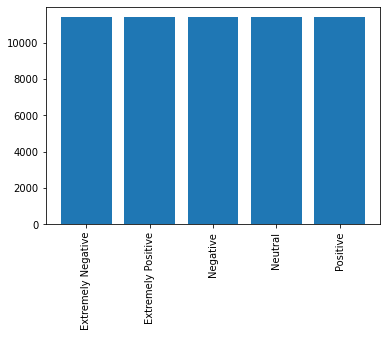

In [ ]:
u, c = np.unique(train_y, return_counts=True)
plt.bar(u,c)
plt.xticks(u, rotation='vertical');

#1.Word Embeddings

In [ ]:
# Word2vec
import gensim
from gensim.models import Word2Vec

from keras.preprocessing.text import Tokenizer

In [ ]:
# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

##1.1.Compute word2vec

###1.1.0 Download existing model

In [ ]:
!cp '/content/drive/My Drive/2.Projects/Covid Tweet Sentiment Classification/models/covid_tweet_w2v.model' word2vec.model

In [ ]:
w2v_model = Word2Vec.load("word2vec.model")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


###1.1.1.Or Compute

In [ ]:
documents = [text.split() for text in train_x]

In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [ ]:
w2v_model.build_vocab(documents)

2020-09-14 16:19:31,440 : INFO : collecting all words and their counts
2020-09-14 16:19:31,442 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-09-14 16:19:31,495 : INFO : PROGRESS: at sentence #10000, processed 192481 words, keeping 15566 word types
2020-09-14 16:19:31,546 : INFO : PROGRESS: at sentence #20000, processed 380810 words, keeping 24208 word types
2020-09-14 16:19:31,596 : INFO : PROGRESS: at sentence #30000, processed 565157 words, keeping 31520 word types
2020-09-14 16:19:31,647 : INFO : PROGRESS: at sentence #40000, processed 749170 words, keeping 38309 word types
2020-09-14 16:19:31,703 : INFO : PROGRESS: at sentence #50000, processed 957310 words, keeping 39000 word types
2020-09-14 16:19:31,738 : INFO : collected 39000 word types from a corpus of 1077096 raw words and 56985 sentences
2020-09-14 16:19:31,739 : INFO : Loading a fresh vocabulary
2020-09-14 16:19:31,767 : INFO : effective_min_count=10 retains 6335 unique words (16% of origi

In [ ]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 6335


In [ ]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-09-14 16:20:16,302 : INFO : training model with 8 workers on 6335 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-09-14 16:20:17,347 : INFO : EPOCH 1 - PROGRESS: at 75.41% examples, 634859 words/s, in_qsize 14, out_qsize 1
2020-09-14 16:20:17,562 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-09-14 16:20:17,577 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-09-14 16:20:17,592 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-09-14 16:20:17,595 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-09-14 16:20:17,600 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-14 16:20:17,603 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-14 16:20:17,608 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-14 16:20:17,612 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-1

CPU times: user 2min 35s, sys: 1.05 s, total: 2min 36s
Wall time: 42.4 s


(27865567, 34467072)

In [ ]:
## We can see the neighbors for 'covid'
w2v_model.most_similar("covid")

2020-09-14 17:03:39,611 : INFO : precomputing L2-norms of word weight vectors


[('coronaviru', 0.2762545049190521),
 ('highriskcovid', 0.2422848641872406),
 ('fightcovid', 0.2326599359512329),
 ('convid', 0.21754299104213715),
 ('coronavirussouthafrica', 0.21075555682182312),
 ('diseas', 0.20423263311386108),
 ('corvid', 0.1931236982345581),
 ('lockdowneffect', 0.18478627502918243),
 ('ncov', 0.17867887020111084),
 ('coronavirusinpakistan', 0.175050750374794)]

##1.2. Compute embedding matrix

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_x)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 36691


In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(36691, 300)


#2.ML (feat.Boosting), might want to work with tf-idf data

In [ ]:
from keras.preprocessing.sequence import pad_sequences

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb

from sklearn.metrics  import accuracy_score

In [ ]:
# ML
SEQUENCE_LENGTH = 70  #For fixing each instance x with a set size
SEED = 0

##2.1. Reshaping data

In [ ]:
## Mind the names (train_x has sentences, x_train has sequences)!
x_train = pad_sequences(tokenizer.texts_to_sequences(train_x), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_x), maxlen=SEQUENCE_LENGTH)

In [ ]:
train_x.shape

(56985,)

In [ ]:
train_x_ML = np.zeros((train_x.shape[0], 1))
for i, row in enumerate(tqdm(x_train)):
    train_x_ML[i] = np.mean([embedding_matrix[x] for x in row])

test_x_ML = np.zeros((test_x.shape[0], 1))
for i, row in enumerate(tqdm(x_test)):
    test_x_ML[i] = np.mean([embedding_matrix[x] for x in row])

100%|██████████| 3793/3793 [00:00<00:00, 14922.11it/s]


##2.3.OR using just tfidf

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics  import accuracy_score
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import LabelEncoder

In [ ]:
# Get training and validation data
X_train, X_val, y_train, y_val = train_test_split(train_x, 
                                                  train_y, 
                                                  test_size=0.2, 
                                                  random_state=SEED)

# Get sentiment labels for test set
# y_test = test_set['airline_sentiment']

In [ ]:
# Create matrix based on word frequency in tweets
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(test_x)

In [ ]:
# Print the size of our data
print(f'Training size: {X_train.shape[0]} tweets\n\
Validation size: {X_val.shape[0]} tweets\n\
Test size: {X_test.shape[0]} tweets\n\
Amount of words (columns): {X_train.shape[1]} words')

Training size: 45588 tweets
Validation size: 11397 tweets
Test size: 3793 tweets
Amount of words (columns): 32948 words


In [ ]:
X_val.shape

(11397, 32948)

##2.4.Naive Bayes

In [ ]:
# Multinomial Naive Bayes
multi_nb = MultinomialNB()
multi_nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
# Check results
train_pred = multi_nb.predict(X_train)
val_pred = multi_nb.predict(X_val)
print(f'Accuracy on training set (MultinomialNB): {round(accuracy_score(y_train, train_pred)*100, 4)}%')
print(f'Accuracy on validation set (MultinomialNB): {round(accuracy_score(y_val,val_pred)*100, 4)}%')

Accuracy on training set (MultinomialNB): 73.368%
Accuracy on validation set (MultinomialNB): 57.638%


##2.3.Gradient Boost

In [ ]:
# sklearn's Gradient Boosting Classifier (GBM)
gbm = GradientBoostingClassifier(n_estimators=200, 
                                 max_depth=6, 
                                 random_state=SEED)
gbm.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=6,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
# Check results
train_pred = gbm.predict(X_train)
val_pred = gbm.predict(X_val)
print(f'Accuracy on training set (GBM): {round(accuracy_score(y_train, train_pred)*100, 4)}%')
print(f'Accuracy on validation set (GBM): {round(accuracy_score(y_val,val_pred)*100, 4)}%')

Accuracy on training set (GBM): 78.1763%
Accuracy on validation set (GBM): 65.2716%


##2.4.XG Boost

In [ ]:
# Hyperparameters that you can tweak
# There are a lot more tweakable hyperparameters that you can find at 
# https://xgboost.readthedocs.io/en/latest/parameter.html
xgb_params = {'objective' : 'multi:softmax',
              'eval_metric' : 'mlogloss',
              'eta' : 0.1,
              'max_depth' : 6,
              'num_class' : 5,
              'lambda' : 0.8,
              'estimators' : 200,
              'seed' : SEED
              
}

# Transform categories into numbers
# negative = 0, neutral = 1 and positive = 2
encoder = LabelEncoder()
encoder.fit(y_train)

target_train = encoder.transform(y_train)
target_val = encoder.transform(y_val)

# target_train = y_train
# target_val = pd.Series(y_val).astype('category').cat.codes


# Transform data into a matrix so that we can use XGBoost
d_train = xgb.DMatrix(X_train, label = target_train)
d_val = xgb.DMatrix(X_val, label = target_val)

# Fit XGBoost
watchlist = [(d_train, 'train'), (d_val, 'validation')]
bst = xgb.train(xgb_params, 
                d_train, 
                400,  
                watchlist,
                early_stopping_rounds = 50, 
                verbose_eval = 0)

In [ ]:
# Check results for XGBoost
train_pred = bst.predict(d_train)
val_pred = bst.predict(d_val)
print(f'Accuracy on training set (XGBoost): {round(accuracy_score(target_train, train_pred)*100, 4)}%')
print(f'Accuracy on validation set (XGBoost): {round(accuracy_score(target_val, val_pred)*100, 4)}%')

Accuracy on training set (XGBoost): 79.556%
Accuracy on validation set (XGBoost): 66.0876%


In [ ]:
y_test = test_y

In [ ]:
# Multinomial Naive Bayes
multinb_test_pred = multi_nb.predict(X_test)

# Gradient Boosting Classifier
gbm_test_pred = gbm.predict(X_test)

# XGBoost
# Transform test data for XGBoost
target_test = encoder.transform(y_test)
d_test = xgb.DMatrix(X_test, label = target_test)
xgboost_test_pred = bst.predict(d_test)

In [ ]:
# Get accuracies
print(f'Accuracy for Multinomial Naive Bayes: {round(accuracy_score(y_test, multinb_test_pred)*100, 4)}%')
print(f'Accuracy for Gradient Boosting Classifier: {round(accuracy_score(y_test, gbm_test_pred)*100, 4)}%')
print(f'Accuracy for XGBoost: {round(accuracy_score(target_test, xgboost_test_pred)*100, 4)}%')

Accuracy for Multinomial Naive Bayes: 44.7667%
Accuracy for Gradient Boosting Classifier: 51.5423%
Accuracy for XGBoost: 52.8342%


#3.CNN

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from keras.preprocessing.text import Tokenizer as keras_tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
from keras.models import Model
from keras import utils

In [ ]:
# KERAS
SEQUENCE_LENGTH = 70
EPOCHS = 8
BATCH_SIZE = 1024

EMBEDDING_DIM = W2V_SIZE
FILTER_SIZES = [3,4,5]
NUM_FILTERS = 512
DROP=0.5

In [ ]:
tokenizer = keras_tokenizer()
tokenizer.fit_on_texts(train_x)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 36691


In [ ]:
## Mind the names (train_x has sentences, x_train has sequences)!
x_train = pad_sequences(tokenizer.texts_to_sequences(train_x), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_x), maxlen=SEQUENCE_LENGTH)

In [ ]:
encoder = LabelEncoder()
encoder.fit(train_y)

y_train = encoder.transform(train_y)
y_train = utils.to_categorical(y_train)

y_test = encoder.transform(test_y)
y_test = utils.to_categorical(y_test)

Model

In [ ]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [ ]:
inputs = Input(shape=(SEQUENCE_LENGTH,), dtype='int32')
embedding = embedding_layer(inputs)
reshape = Reshape((SEQUENCE_LENGTH, EMBEDDING_DIM,1))(embedding)

conv_0 = Conv2D(NUM_FILTERS, kernel_size=(FILTER_SIZES[0], EMBEDDING_DIM), padding='valid', activation='relu')(reshape)
conv_1 = Conv2D(NUM_FILTERS, kernel_size=(FILTER_SIZES[1], EMBEDDING_DIM), padding='valid', activation='relu')(reshape)
conv_2 = Conv2D(NUM_FILTERS, kernel_size=(FILTER_SIZES[2], EMBEDDING_DIM), padding='valid', activation='relu')(reshape)

pool_0 = MaxPool2D(pool_size=(SEQUENCE_LENGTH-FILTER_SIZES[0]+1, 1), strides=(1,1), padding='valid')(conv_0)
pool_1 = MaxPool2D(pool_size=(SEQUENCE_LENGTH-FILTER_SIZES[1]+1, 1), strides=(1,1), padding='valid')(conv_1)
pool_2 = MaxPool2D(pool_size=(SEQUENCE_LENGTH-FILTER_SIZES[2]+1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([pool_0, pool_1, pool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(DROP)(flatten)
outputs = Dense(units=5, activation='softmax')(dropout)

cnn = Model(inputs=inputs, outputs=outputs)

In [ ]:
cnn.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 70, 300)      11007300    input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 70, 300, 1)   0           embedding[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 68, 1, 512)   461312      reshape[0][0]                    
_______________________________________________________________________________________

In [ ]:
cnn.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
history_cnn = cnn.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1)


Epoch 1/8
51/51 [==============================] - 10s 192ms/step - loss: 1.2367 - accuracy: 0.4906 - val_loss: 1.1085 - val_accuracy: 0.6122
Epoch 2/8
51/51 [==============================] - 10s 188ms/step - loss: 0.9512 - accuracy: 0.6195 - val_loss: 0.8904 - val_accuracy: 0.7266
Epoch 3/8
51/51 [==============================] - 10s 189ms/step - loss: 0.8104 - accuracy: 0.6864 - val_loss: 0.7228 - val_accuracy: 0.7952
Epoch 4/8
51/51 [==============================] - 10s 189ms/step - loss: 0.7114 - accuracy: 0.7298 - val_loss: 0.5142 - val_accuracy: 0.8687
Epoch 5/8
51/51 [==============================] - 10s 189ms/step - loss: 0.6409 - accuracy: 0.7567 - val_loss: 0.3955 - val_accuracy: 0.9086
Epoch 6/8
51/51 [==============================] - 10s 189ms/step - loss: 0.5802 - accuracy: 0.7832 - val_loss: 0.3542 - val_accuracy: 0.9256
Epoch 7/8
51/51 [==============================] - 10s 189ms/step - loss: 0.5231 - accuracy: 0.8053 - val_loss: 0.3103 - val_accuracy: 0.9310
Epoch 

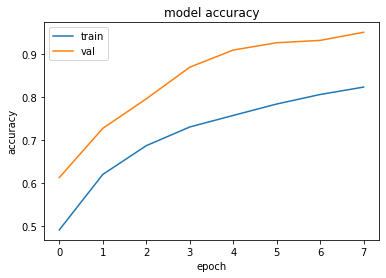

In [ ]:
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
score = cnn.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

4/4 [==============================] - 0s 55ms/step - loss: 1.1949 - accuracy: 0.5537

ACCURACY: 0.5536514520645142
LOSS: 1.1948870420455933


#4.BERT

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.0MB 5.4MB/s 
     |████████████████████████████████| 1.1MB 32.5MB/s 
     |████████████████████████████████| 890kB 14.9MB/s 
     |████████████████████████████████| 3.0MB 42.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=a89b852794670208b8264419beb375b1ba900232df8e31b7db82bc4d26fa5679
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from transformers import BertTokenizer, TFBertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
def bert_encode(data,maximum_length) :
    input_ids = []
    attention_masks = []


    for text in tqdm(data):
        encoded = tokenizer.encode_plus(

        text,
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,

        return_attention_mask=True,

        truncation=True
      )

        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [ ]:
train_input_ids,train_attention_masks = bert_encode(train_x,SEQUENCE_LENGTH)

  0%|          | 0/56985 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 56985/56985 [00:25<00:00, 2276.40it/s]


In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
def create_model(bert_model):
    input_ids = tf.keras.Input(shape=(SEQUENCE_LENGTH,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(SEQUENCE_LENGTH,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(DROP)(output)

    output = tf.keras.layers.Dense(5,activation='softmax')(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=6e-6), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = create_model(bert_model)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 70, 768), (N 109482240   input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           24608       tf_bert_model[0][1]   

In [ ]:
bert_history = model.fit([train_input_ids,train_attention_masks],y_train,validation_split=0.2, epochs=3,batch_size=50)

Epoch 1/3
912/912 [==============================] - 409s 449ms/step - loss: 1.3607 - accuracy: 0.4082 - val_loss: 0.9355 - val_accuracy: 0.6136
Epoch 2/3
912/912 [==============================] - 408s 448ms/step - loss: 1.0532 - accuracy: 0.5938 - val_loss: 0.7496 - val_accuracy: 0.7132
Epoch 3/3
912/912 [==============================] - 409s 448ms/step - loss: 0.9181 - accuracy: 0.6691 - val_loss: 0.6060 - val_accuracy: 0.7841


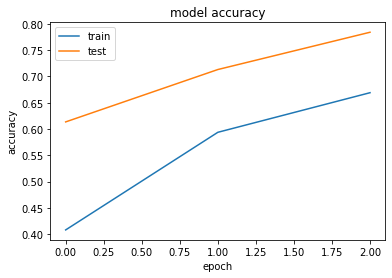

In [ ]:
plt.plot(bert_history.history['accuracy'])
plt.plot(bert_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

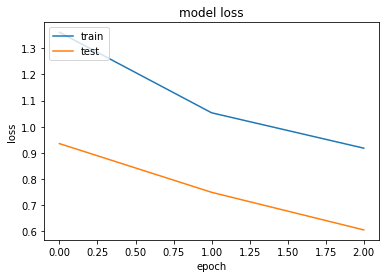

In [ ]:
plt.plot(bert_history.history['loss'])
plt.plot(bert_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
test_input_ids,test_attention_masks = bert_encode(test_x,SEQUENCE_LENGTH)

  0%|          | 0/3793 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 3793/3793 [00:01<00:00, 2196.30it/s]


In [ ]:
score = model.evaluate([test_input_ids,test_attention_masks], y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

4/4 [==============================] - 6s 2s/step - loss: 0.9406 - accuracy: 0.6538

ACCURACY: 0.6538360118865967
LOSS: 0.940627932548523
